In [1]:
import pandas as pd

import os
import time

import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

# 코드 다시 돌리기 위한 seed 고정
import random
import numpy as np
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import *

%matplotlib inline


In [2]:
class MyModel(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(MyModel, self).__init__()
        """Base Model"""
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 100)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x  

In [3]:
model = MyModel(3, 100).to(device)
model

MyModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=100, bias=True)
)

In [6]:
train_transform = transforms.Compose([    
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])        

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])    

train = torchvision.datasets.CIFAR100(root="./", train=True, download=True, transform=train_transform)
test = torchvision.datasets.CIFAR100(root="./", train=False, download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train, batch_size=256,
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test, batch_size=256,
                                          shuffle=False, num_workers=2)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
criterion = nn.CrossEntropyLoss()

NameError: ignored

In [ ]:
for epoch in range(20):
    model.train()
    running_loss = 0.0
    best_acc = 0.0
    best_model_wts = model.state_dict()
    print(f"train epoch: {epoch+1}----------------")
    for img, label in tqdm(train_loader):
        img = img.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, label)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    correct, all_data = 0,0
    print("\ntrain_loss : ", running_loss / len(train_loader))
    model.eval()
    for img, label in test_loader:
        with torch.no_grad():
            img = img.to(device)
            label = label.to(device)
            output = model(img)

            correct += torch.sum(torch.argmax(output, dim=1) == label).item()
            all_data += len(label)
    print("val_acc : ", correct / all_data)
    if correct / all_data > best_acc:
      best_acc = correct / all_data
      best_model_wts = model.state_dict()

Baseline model의 accuracy는 0.2 정도이다.
더 정확한 예측을 하기 위해 

1. Deeper Network
2. Batch Normalization
3. Use Dropout
4. Use Data Augmentation 

등을 할 수 있다.



In [7]:
batch_size = 400
epochs = 120
max_lr = 0.001
grad_clip = 0.01
weight_decay =0.001
opt_func = torch.optim.Adam

In [8]:
train_data = torchvision.datasets.CIFAR100('./', train=True, download=True)

# Stick all the images together to form a 1600000 X 32 X 3 array
x = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))])

# calculate the mean and std along the (0, 1) axes
mean = np.mean(x, axis=(0, 1))/255
std = np.std(x, axis=(0, 1))/255
# the the mean and std
mean=mean.tolist()
std=std.tolist()

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar-100-python.tar.gz to ./


In [9]:
transform_train = tt.Compose([tt.RandomCrop(32, padding=4,padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(mean,std,inplace=True)])
transform_test = tt.Compose([tt.ToTensor(), tt.Normalize(mean,std)])

In [10]:
trainset = torchvision.datasets.CIFAR100("./",
                                         train=True,
                                         download=True,
                                         transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size, shuffle=True, num_workers=2,pin_memory=True)

testset = torchvision.datasets.CIFAR100("./",
                                        train=False,
                                        download=True,
                                        transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size*2,pin_memory=True, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
trainloader = DeviceDataLoader(trainloader, device)
testloader = DeviceDataLoader(testloader, device)

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True) 
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) 
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True) 
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) 
        self.conv5 = conv_block(512, 1028, pool=True) 
        self.res3 = nn.Sequential(conv_block(1028, 1028), conv_block(1028, 1028))  
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2), # 1028 x 1 x 1
                                        nn.Flatten(), # 1028 
                                        nn.Linear(1028, num_classes)) # 1028 -> 100
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out

model = to_device(ResNet9(3, 100), device)
model
      

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [14]:
@torch.no_grad()
def evaluate(model, test_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, test_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [15]:
# Initial evaluation
history = [evaluate(model, testloader)]
history

[{'val_loss': 4.6053924560546875, 'val_acc': 0.010192306712269783}]

In [16]:
# Fitting the first 1/4 epochs
current_time=time.time()
history += fit_one_cycle(int(epochs/4), max_lr, model, trainloader, testloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)


Epoch [0], last_lr: 0.00007, train_loss: 3.6436, val_loss: 3.0884, val_acc: 0.2512
Epoch [1], last_lr: 0.00015, train_loss: 2.8980, val_loss: 2.7001, val_acc: 0.3163
Epoch [2], last_lr: 0.00028, train_loss: 2.5563, val_loss: 2.4407, val_acc: 0.3676
Epoch [3], last_lr: 0.00044, train_loss: 2.3169, val_loss: 2.6123, val_acc: 0.3580
Epoch [4], last_lr: 0.00060, train_loss: 2.0952, val_loss: 2.4009, val_acc: 0.3884
Epoch [5], last_lr: 0.00076, train_loss: 1.9346, val_loss: 2.4791, val_acc: 0.3874
Epoch [6], last_lr: 0.00089, train_loss: 1.7935, val_loss: 2.2957, val_acc: 0.4273
Epoch [7], last_lr: 0.00097, train_loss: 1.6455, val_loss: 1.8441, val_acc: 0.4974
Epoch [8], last_lr: 0.00100, train_loss: 1.5153, val_loss: 1.8517, val_acc: 0.4925
Epoch [9], last_lr: 0.00099, train_loss: 1.3933, val_loss: 1.7089, val_acc: 0.5276
Epoch [10], last_lr: 0.00098, train_loss: 1.2814, val_loss: 1.7849, val_acc: 0.5218
Epoch [11], last_lr: 0.00095, train_loss: 1.1987, val_loss: 1.6226, val_acc: 0.5647
Ep

In [17]:
# Fitting the second 1/4 epochs
history += fit_one_cycle(int(epochs/4), max_lr/10, model, trainloader, testloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)


KeyboardInterrupt: ignored

In [ ]:
history += fit_one_cycle(int(epochs/8), max_lr/100, model, trainloader, testloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)


In [ ]:
history += fit_one_cycle(int(epochs/8), max_lr/1000, model, trainloader, testloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

In [ ]:
history += fit_one_cycle(int(epochs/4), max_lr/100, model, trainloader, testloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)
# Print training time
print('Training time: {:.2f} s'.format(time.time() - current_time))

In [18]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-o')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Accuracy Vs No.of epochs')

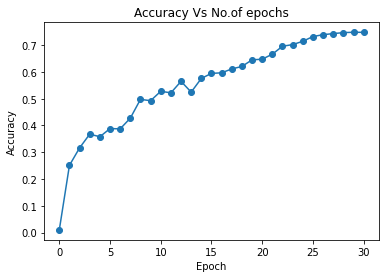

In [19]:
plot_accuracies(history)
